In [106]:
import os
import copy
import h5py
from six.moves import cPickle as pickle
from glob import glob
from random import shuffle

import cv2
from PIL import Image

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, BatchNormalization, Convolution2D, Dense, Dropout, MaxPooling2D, Flatten

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from keras.datasets import mnist

import matplotlib.pyplot as plt


#### Задание 1. Реализуйте глубокую нейронную сеть (полносвязную или сверточную) и обучите ее на синтетических данных (например, наборы MNIST (http://yann.lecun.com/exdb/mnist/) или notMNIST). Ознакомьтесь с имеющимися работами по данной тематике: англоязычная статья (http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf), видео на YouTube (https://www.youtube.com/watch?v=vGPI_JvLoN0).

In [20]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 5s 0us/step


In [21]:
def create_numbers(numbers, number_labels, maxlength=5, digit_sz=(28, 28), return_label=False):
    img_len = np.random.choice(range(maxlength)) + 1
    label = np.empty(5, dtype='str')
    
    if img_len < maxlength:
        st_point = np.random.choice(maxlength - img_len)
    else:
        st_point = 0
    
    charmap = np.zeros(maxlength)
    charmap[st_point:st_point + img_len] = 1
    blank_lbl = "."

    new_img_len = maxlength * digit_sz[1]
    new_img = np.zeros((digit_sz[0], new_img_len))
    
    for i, b in enumerate(charmap):
        if b > 0:
            n = np.random.choice(len(numbers))
            st_pos = i * digit_sz[1]
            new_img[:, st_pos:st_pos + digit_sz[1]] = numbers[n]
            label[i] = str(number_labels[n])
        else:
            label[i] = blank_lbl

    if return_label:
        return new_img, label

    return new_img

['3' '0' '2' '2' '8']


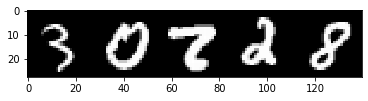

In [120]:
img, label = create_numbers(x_train, y_train, return_label=True)
plt.imshow(img, cmap='gray')

In [27]:
def generator(numbers, number_labels, batch_size=32):
    while True:

        images = []
        labels = []

        for batch_sample in range(batch_size):
            img, label = create_numbers(numbers, number_labels, return_label=True)
            
            n_label = np.zeros((5, 11), dtype='int')
            for i, digit in enumerate(label):
                if digit == ".":
                    n = 10
                else:
                    n = int(digit)

                n_label[i][n] = 1
                

            images.append(img)
            labels.append(n_label)

        X_train = np.array(images)
        if len(X_train.shape) == 3:
            X_train = np.expand_dims(X_train, -1)

        y_temp = np.array(labels)
        
        y1 = y_temp[:, 0, :]
        y2 = y_temp[:, 1, :]
        y3 = y_temp[:, 2, :]
        y4 = y_temp[:, 3, :]
        y5 = y_temp[:, 4, :]

        yield X_train, [y1, y2, y3, y4, y5]

In [28]:
def convert_label(label):
    n_label = ""
    for digit in label:
        if np.argmax(digit) == 10:
            n_digit = "."
        else:
            n_digit = str(np.argmax(digit))
        n_label += n_digit
    return n_label

In [29]:
i = 0
for a, b in generator(x_train, y_train, batch_size=16): 
    test_imgs = a
    test_lbls = b
    
    i += 1
    
    if i > 1:
        break

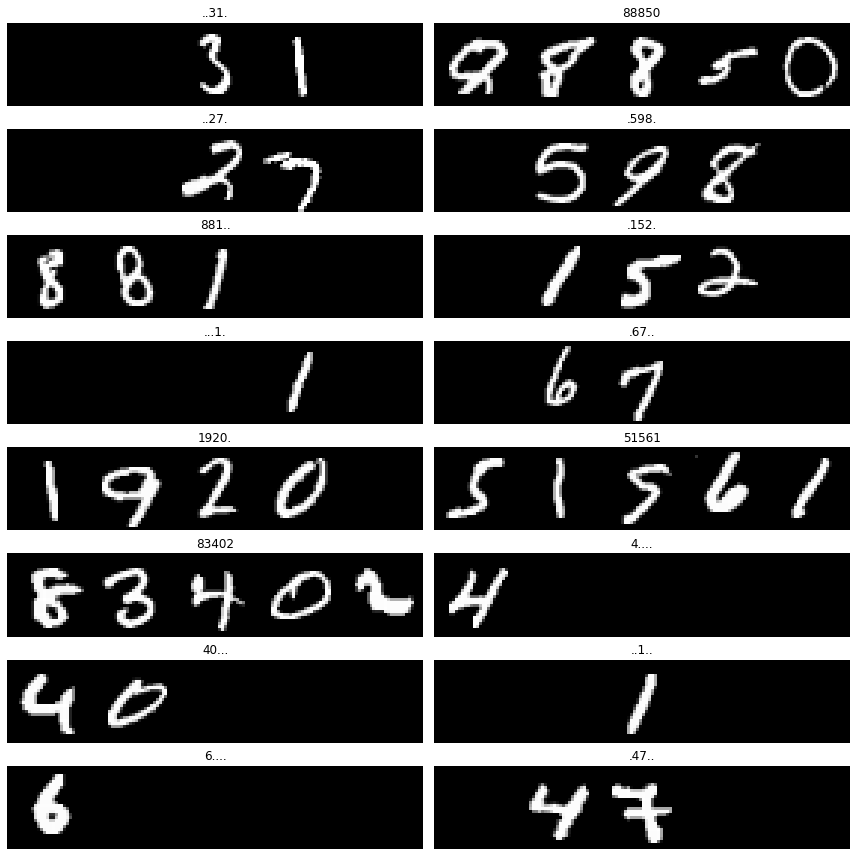

In [30]:
rows_to_plot = 8
cols_to_plot = 2

f = plt.figure(figsize=(12, 12))

for i in range(16):
    f.add_subplot(rows_to_plot, cols_to_plot, i+1)
    plt.title(convert_label(np.vstack((test_lbls[0][i], test_lbls[1][i], test_lbls[2][i], 
                                                test_lbls[3][i],test_lbls[4][i]))))
    plt.imshow(test_imgs[i][:, :, 0], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

#### End-to-end model

In [31]:

def get_model(input_shape=(28, 28*5, 3), p=0.5, n_class=11):

    inputs = Input(((input_shape[0], input_shape[1], input_shape[2])))
    
    x = BatchNormalization()(inputs)
    x = Convolution2D(48, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(p/4)(x)
    
    x = BatchNormalization()(x)
    x = Convolution2D(64, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = Dropout(p/4)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(128, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(p/2)(x)

    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    
    c1 = Dense(n_class, activation='softmax')(x)
    c2 = Dense(n_class, activation='softmax')(x)
    c3 = Dense(n_class, activation='softmax')(x)
    c4 = Dense(n_class, activation='softmax')(x)
    c5 = Dense(n_class, activation='softmax')(x)
    
    output = [c1, c2, c3, c4, c5]
    
    model = Model(inputs=inputs, outputs=output)

    return model


In [32]:
def convert_output(model_output):
    model_output = np.array(model_output).swapaxes(0, 1)
    labels = []
    for output in model_output:
        label = convert_label(output)
        labels.append(label)

    return labels



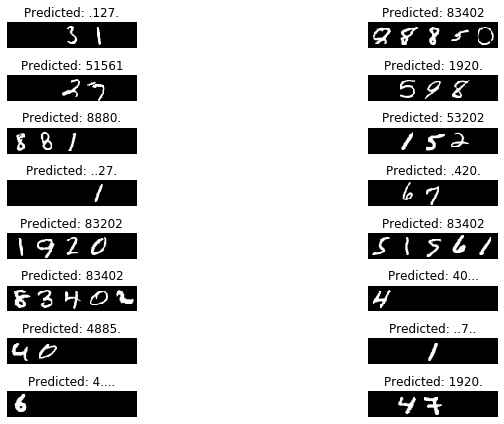

In [79]:
output = convert_output(teste_out
rows_to_plot = len(list(zip(output, test_imgs))) // 2
cols_to_plot = 2

f = plt.figure(figsize=(12, 6))

for i, (pred, img) in enumerate(zip(output, test_imgs)):
    f.add_subplot(rows_to_plot, cols_to_plot, i+1)
    plt.title("Predicted: " + pred)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.axis('off')

plt.show()

#### Train the model

In [80]:
model = get_model(input_shape=(28, 28*5, 1))
optimizer = Adam(lr=1e-3)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit_generator(trn_generator,
                    epochs=2,
                    steps_per_epoch=780,
                    validation_data=validation_generator,
                    validation_steps=780,
                    verbose=1)

In [83]:
i = 0
for test_set, test_labels in generator(x_train, y_train, batch_size=1000): 

    i += 1

    if i > 1:
        break

In [84]:
model.evaluate(test_set, test_labels)
test_pred = model.predict(test_set)

1000/1000 [==============================] - 11s 11ms/step


[0.08459595651365817,
 0.021845726296305656,
 0.034062646329402924,
 0.008139328099787235,
 0.023877732455730438,
 0.00385863333940506,
 0.9959999918937683,
 0.9940000176429749,
 0.9990000128746033,
 0.9919999837875366,
 0.9990000128746033]

In [86]:
test_pred_labels = convert_output(test_pred)
test_true_labels = convert_output(test_labels)

Predicted:  708..
Ground Truth:  708..


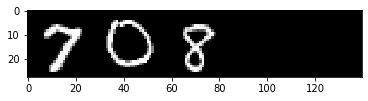

In [94]:
ref = 542
print("Predicted: ", test_pred_labels[ref])
print("Ground Truth: ", test_true_labels[ref])

plt.imshow(test_set[ref][:, :, 0], cmap='gray')


In [100]:
accuracy = accuracy_score(test_true_labels, test_pred_labels)

In [101]:
print("Accuracy: ", accuracy*100, "%")


Accuracy:  98.0 %


In [82]:
model.load_weights('./models/ass4_step1.h5')

#### Задание 2. После уточнения модели на синтетических данных попробуйте обучить ее на реальных данных (набор Google Street View). Что изменилось в модели?

In [155]:
path = '/Users/konstantin/PycharmProjects/deep-learning-course'
dataset_path = f'{path}/data/'

In [156]:
train_filenames = glob(dataset_path + '/train/*.png')

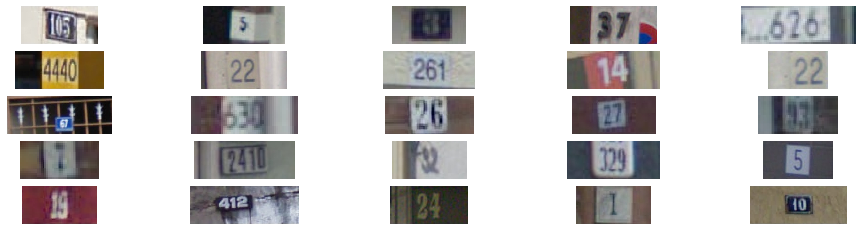

In [158]:
rows_to_plot = 5
cols_to_plot = 5

f = plt.figure(figsize=(16, 4))

for i, fn in enumerate(np.random.choice(len(train_filenames), rows_to_plot * cols_to_plot)):
    f.add_subplot(rows_to_plot, cols_to_plot, i+1)
    plt.imshow(Image.open(train_filenames[fn], mode='r'))
    plt.axis('off')

plt.show()

In [175]:
def readAndSaveMetadata(filepath):
    # Forked from https://discussions.udacity.com/t/how-to-deal-with-mat-files/160657/3
    
    # Load the given MatLab file
    f = h5py.File(filepath, 'r')
    fn = filepath.split('/')[-1]
    
    # Create our empty dictionary
    metadata= {}
    metadata['height'] = []
    metadata['label'] = []
    metadata['left'] = []
    metadata['top'] = []
    metadata['width'] = []
    
    # define a function to pass to h5py's visititems() function
    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(obj[0][0])
        else:
            for k in range(obj.shape[0]):
                vals.append(f[obj[k][0]][0][0])
        metadata[name].append(vals)
    
    # Add information to metadata
    for item in f['/digitStruct/bbox']:
        f[item[0]].visititems(print_attrs)
    
    # Save to a pickle file
    pickle_file = filepath + '.pickle'
    try:
      pickleData = open(pickle_file, 'wb')
      pickle.dump(metadata, pickleData, pickle.HIGHEST_PROTOCOL)
      pickleData.close()
    except Exception as e:
      print('Unable to save data to', pickle_file, ':', e)
      raise

In [176]:
readAndSaveMetadata(dataset_path + '/train/digitStruct.mat')
readAndSaveMetadata(dataset_path + '/test/digitStruct.mat')

In [181]:
f = open('./data/train/digitStruct.mat.pickle', 'rb')
trn_data = pickle.load(f)
trn_data = pd.DataFrame.from_dict(trn_data)

f = open('./data/test/digitStruct.mat.pickle', 'rb')
tst_data = pickle.load(f)
tst_data = pd.DataFrame.from_dict(tst_data)

In [182]:
trn_label_len = []
for label in trn_data['label']:
    label_len = len(label)
    trn_label_len.append(label_len)


In [185]:
def generate_crop(filepath, dataframe, expand_by=0.3, verbose=0, crop_sz=(64, 64), random_crop=True):
    """
    This function expects a filepath of an image and will return either a 64 x 64 crop
    or a 54 x 54 random crop of the street number depending on the random_crop parameter.
    
    """
    # 1 - open the image and store img dimensions
    img = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_h = img.shape[0]
    img_w = img.shape[1]

    if verbose > 0:
        print("img_h: ", img_h, "    img_w: ", img_w, "\n")

    # 2 - find bounding box for whole street number
    fn = filepath.split('/')[-1].split('.')[0]

    left = np.min(dataframe.loc[int(fn) - 1].left)
    top = np.min(dataframe.loc[int(fn) - 1].top)
    bottom = (np.max(dataframe.loc[int(fn) - 1].top) + np.max(dataframe.loc[int(fn) - 1].height))
    right = (np.max(dataframe.loc[int(fn) - 1].left) + np.max(dataframe.loc[int(fn) - 1].width))

    if verbose>0:
        print("left: ", left, "    right: ", right, "    top: ", top, "    bottom: ", bottom, "\n")

    # 3 - Expand bounding box by X%
    mid_x = (left + right) // 2
    mid_y = (top + bottom) // 2
    new_h = np.abs(bottom - top) * (1 + expand_by)
    new_w = np.abs(right - left) * (1 + expand_by)

    if verbose > 0:
        print("mid_x: ", mid_x, "    mid_y: ", mid_y, "    new_h: ", new_h, "    new_w: ", new_w, "\n")
    
    # New points will be determined by the calculations above and the original image size
    left = np.max((0, mid_x - new_w // 2)).astype(np.uint)
    right = np.min((img_w, mid_x + new_w // 2)).astype(np.uint)
    top = np.max((0, mid_y - new_h // 2)).astype(np.uint)
    bottom = np.min((img_h, mid_y + new_h // 2)).astype(np.uint)

    if verbose>0:
        print("n_left: ", left, "    n_right: ", right, "    n_top: ", top, "    n_bottom: ", bottom, "\n")
    
    # 4 - Crop image within bounding box
    cropped = img[top:bottom, left:right, :].copy()

    # 5 - Rescale to 64 x 64
    rescaled = cv2.resize(cropped, crop_sz)
    
    if random_crop:
        dx = np.random.randint(0, 10)
        dy = np.random.randint(0, 10)
        rescaled = rescaled[dx:dx+54, dy:dy+54, :]
    
    return rescaled

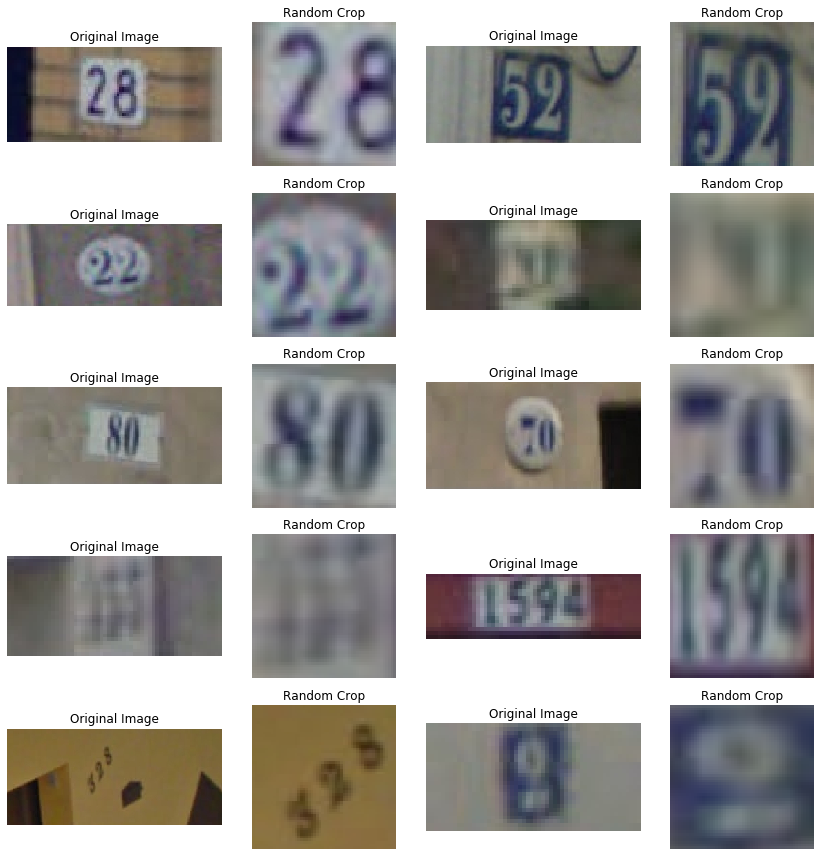

In [186]:
items_to_plot = 10

f = plt.figure(figsize=(12, 12))

i = 0
for fn in np.random.choice(len(train_filenames), items_to_plot):
    # Plot original
    f.add_subplot(items_to_plot // 2, 4, i+1)
    plt.title('Original Image')
    plt.imshow(Image.open(train_filenames[fn], mode='r'))
    plt.axis('off')
    i += 1

    # Plot cropped
    f.add_subplot(items_to_plot // 2, 4, i+1)
    plt.title('Random Crop')
    plt.imshow(generate_crop(train_filenames[fn], trn_data))
    plt.axis('off')
    i += 1

plt.tight_layout()


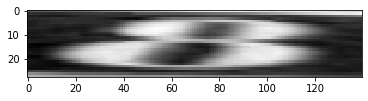

In [188]:
test_img = generate_crop(train_filenames[35], trn_data, crop_sz=(140, 28), random_crop=False)
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
plt.imshow(test_img, cmap='gray')

In [189]:
test_img = np.expand_dims(test_img, -1)

In [192]:
test_pred = model.predict(np.expand_dims(test_img, 0))
test_pred_labels = convert_output(test_pred)
print("Predicted: ", test_pred_labels)

Predicted:  ['11107']


Text(0.5, 1.0, 'Predicted label: 11107')

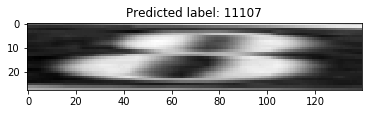

In [193]:
ref = 35
test_img = generate_crop(train_filenames[ref], trn_data, crop_sz=(140, 28), random_crop=False)
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
test_img = np.expand_dims(test_img, -1)
test_pred = model.predict(np.expand_dims(test_img, 0))
test_pred_labels = convert_output(test_pred)

plt.imshow(test_img[:, :, 0], cmap='gray')
plt.title("Predicted label: " + test_pred_labels[0])

In [194]:
def get_label(filepath, dataframe, maxlength=5):


    fn = filepath.split('/')[-1].split('.')[0]

    label = dataframe.loc[int(fn) - 1].label

    l = np.zeros(maxlength+1)
    try:
        l[len(label)] = 1
    except:
        l[0] = 1

    y = np.zeros((5, 11), dtype=int)

    for i in range(5):
        try:
            y[i][int(label[i])] = 1
        except:
            y[i][0] = 1

    return [l, y[0], y[1], y[2], y[3], y[4]]

In [195]:
def new_convert_label(label):
    l = label[0]
    labels = label[1:]
    n_label = ""
    for digit in labels:
        if np.argmax(digit) == 0:
            n_digit = ""
        elif np.argmax(digit) == 10:
            n_digit = "0"
        else:
            n_digit = str(np.argmax(digit))
        n_label += n_digit
    return n_label


print("converted label: ", new_convert_label(get_label(train_filenames[10], trn_data)))
plt.imshow(generate_crop(train_filenames[10], trn_data))


In [198]:
def new_generator(filepath_list, dataframe, batch_size=32, crop_sz=(64, 64),
                  shuffle_data=True, random_crop=True, return_labels=True):

    num_samples = len(filepath_list)
    filelist = copy.copy(filepath_list)

    if shuffle_data:
        shuffle(filelist)

    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples = filelist[offset:offset + batch_size]

            if shuffle_data:
                shuffle(batch_samples)

            images = []
            length = []
            digits = []

            for batch_sample in batch_samples:
                img = generate_crop(batch_sample, dataframe, crop_sz=crop_sz, random_crop=random_crop)
                y = np.zeros((5, 11), dtype='int')
                [l, y[0, :], y[1, :], y[2, :], y[3, :], y[4, :]] = get_label(batch_sample, dataframe)
            
                images.append(img)
                length.append(l)
                digits.append(y)

            X_train = np.array(images)
            if len(X_train.shape) == 3:
                X_train = np.expand_dims(X_train, -1)

            y_temp = np.array(digits)
            l = np.array(length)

            y1 = y_temp[:, 0, :]
            y2 = y_temp[:, 1, :]
            y3 = y_temp[:, 2, :]
            y4 = y_temp[:, 3, :]
            y5 = y_temp[:, 4, :]
            
            if return_labels:
                yield X_train, [l, y1, y2, y3, y4, y5]
            else:
                yield X_train

In [199]:
i = 0
for a, b in new_generator(train_filenames, trn_data, batch_size=25): 
    test_imgs = a
    test_lbls = b
    
    i += 1
    
    if i > 1:
        break

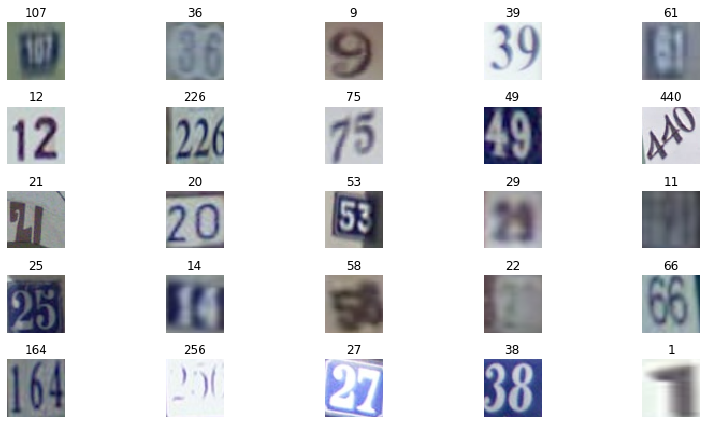

In [200]:
rows_to_plot = 5
cols_to_plot = 5

f = plt.figure(figsize=(12, 6))

for i in range(rows_to_plot * cols_to_plot):
    f.add_subplot(rows_to_plot, cols_to_plot, i+1)
    plt.title(new_convert_label([test_lbls[0][i], test_lbls[1][i], test_lbls[2][i], 
                                 test_lbls[3][i], test_lbls[4][i], test_lbls[5][i]]))
    plt.imshow(test_imgs[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [201]:
def get_new_model(input_shape=(54, 54, 3), p=0.5, n_class=11, n_len=6):

    inputs = Input(((input_shape[0], input_shape[1], input_shape[2])))
    x = BatchNormalization()(x)
    x = Convolution2D(160, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = Dropout(p/2)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(p)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = Dropout(p)(x)
    
    x = BatchNormalization()(x)
    x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(p)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(192, 5, activation='relu', padding='same', strides=(1, 1))(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x)
    x = Dropout(p)(x)
    
    x = Flatten()(x)
    x = Dense(3072, activation='relu')(x)
    x = Dense(3072, activation='relu')(x)

    l = Dense(n_len, activation='softmax')(x)
    c1 = Dense(n_class, activation='softmax')(x)
    c2 = Dense(n_class, activation='softmax')(x)
    c3 = Dense(n_class, activation='softmax')(x)
    c4 = Dense(n_class, activation='softmax')(x)
    c5 = Dense(n_class, activation='softmax')(x)
    
    output = [l, c1, c2, c3, c4, c5]
    
    model = Model(inputs=inputs, outputs=output)

    return model

In [202]:
new_model = get_new_model()


In [212]:
def new_convert_output(model_output):
    l = model_output[0]
    digits = np.array(model_output[1:]).swapaxes(0, 1)
    labels = []
    for i in range(len(l)):
        label = new_convert_label(([l[i]], digits[i, 0, :], digits[i, 1, :],
                                  digits[i, 2, :], digits[i, 3, :], digits[i, 4, :]))
        labels.append(label)

    return labels

In [222]:
trn_filenames, val_filenames = train_test_split(train_filenames, test_size=0.2)

In [239]:
new_model = get_new_model()
optimizer = Adam(lr=1e-3)
new_model.compile(optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
callbacks = [ModelCheckpoint('./models/new_model.{epoch:02d}-{val_loss:.2f}.hdf5')]

trn_generator = new_generator(trn_filenames, trn_data, batch_size=128)
val_generator = new_generator(val_filenames, trn_data, batch_size=128)

In [ ]:
new_model.fit_generator(trn_generator,
                    epochs=5,
                    steps_per_epoch=200,
                    validation_data=val_generator,
                    validation_steps=200,
                    callbacks=callbacks,
                    verbose=1)

In [ ]:
new_model.load_weights('~/paulbahush/models/ass4_step2.h5')

In [225]:
teste_out = new_model.predict(test_imgs)

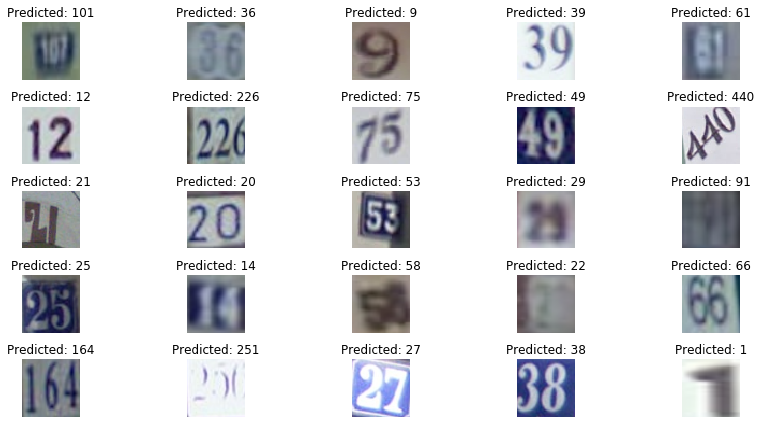

In [226]:
output = new_convert_output(teste_out)

rows_to_plot = 5
cols_to_plot = 5

f = plt.figure(figsize=(12, 6))

for i, (pred, img) in enumerate(zip(output, test_imgs)):
    f.add_subplot(rows_to_plot, cols_to_plot, i+1)
    plt.title("Predicted: " + pred)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [227]:
tst_filenames = glob(dataset_path + '/test/*.png')

In [229]:
tst_imgs = []
tst_labels = []
for filename in tst_filenames:
    img = generate_crop(filename, tst_data, crop_sz=(54, 54), random_crop=False)
    lbl = get_label(filename, tst_data)
    n_lbl = new_convert_label(lbl)
    tst_labels.append(n_lbl)
    tst_imgs.append(img)

tst_imgs = np.array(tst_imgs)

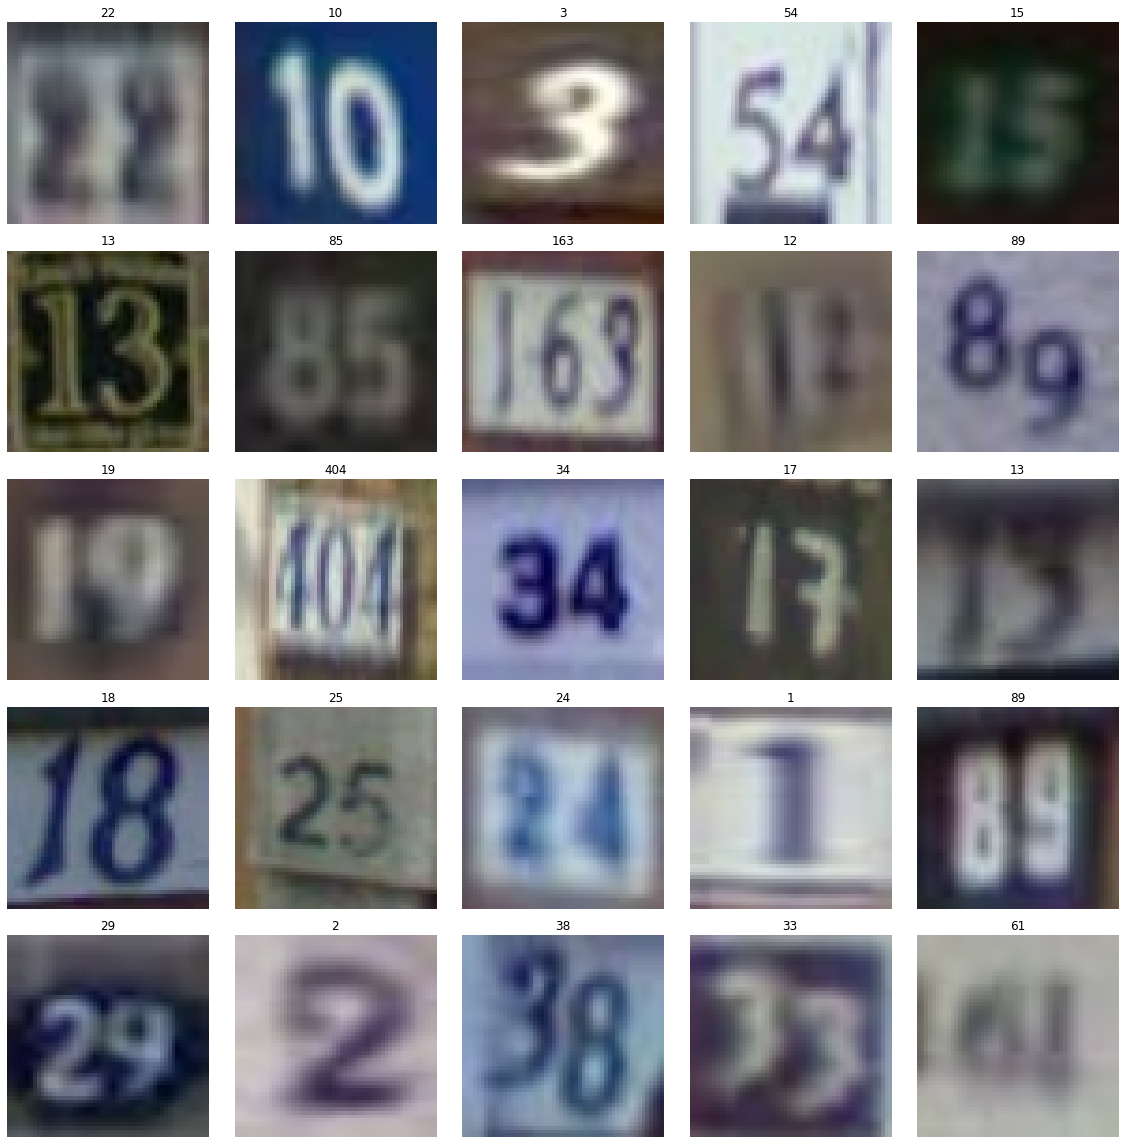

In [230]:
rows_to_plot = 5
cols_to_plot = 5

f = plt.figure(figsize=(16, 16))

for i, fn in enumerate(np.random.choice(len(tst_filenames), rows_to_plot * cols_to_plot)):
    f.add_subplot(rows_to_plot, cols_to_plot, i+1)
    plt.imshow(tst_imgs[fn])
    plt.title(tst_labels[fn])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
tst_pred = new_model.predict(tst_imgs, batch_size=128)
pred_labels = new_convert_output(tst_pred)
tst_accuracy = accuracy_score(tst_labels, pred_labels)

In [235]:
print("Accuracy: ", np.round(tst_accuracy*100, 1), "%")

Accuracy:  83.0 %


In [ ]:
#### Задание 3. Сделайте множество снимков изображений номеров домов с помощью смартфона на ОС Android. Также можно использовать библиотеки OpenCV, Simple CV или Pygame для обработки изображений с общедоступных камер видеонаблюдения (например, https://www.earthcam.com/). Пример использования библиотеки TensorFlow на смартфоне можете воспользоваться демонстрационным приложением от Google (https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android).


In [268]:
new_images = []
new_filenames = []

filelist = os.listdir('~/paulbahush/data/a4/small/')

for file in filelist:

    try:
        img = cv2.imread('~/paulbahush/data/a4/small/' + file, cv2.IMREAD_COLOR)
    except:
        img = None

    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (54, 54))
        new_images.append(img)
        new_filenames.append(file)

In [269]:
new_images = np.array(new_images)
test_new_preds = new_model.predict(new_images)
new_pred_labels = new_convert_output(test_new_preds)

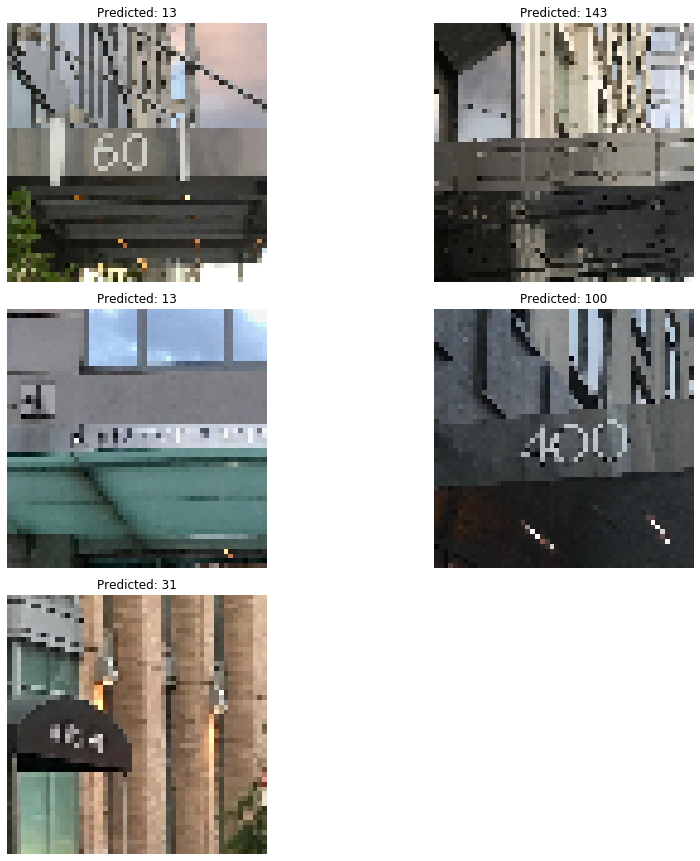

In [270]:
rows_to_plot = 5
cols_to_plot = 2

f = plt.figure(figsize=(12, 20))

for i, (pred, img) in enumerate(zip(new_pred_labels, new_images)):
    f.add_subplot(rows_to_plot, cols_to_plot, i+1)
    plt.title("Predicted: " + pred)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [280]:
new_images = np.array(new_images)
test_new_preds = new_model.predict(new_images)
new_pred_labels = new_convert_output(test_new_preds)

rows_to_plot = 5
cols_to_plot = 2

f = plt.figure(figsize=(12, 20))

for i, (pred, img) in enumerate(zip(new_pred_labels, new_images)):
    f.add_subplot(rows_to_plot, cols_to_plot, i+1)
    plt.title("Predicted: " + pred)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()